In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
# 查询系统可用的 GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# 确保有可用的 GPU 如果没有, 则会报错
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# 设置参数,该段务必在运行jupyter的第一段代码执行，否则会无法初始化成功
# 仅在需要时申请显存空间（程序初始运行时消耗很少的显存，随着程序的运行而动态申请显存）
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### 1. tf.data初探
- 面对一堆格式不一的原始数据文件？读入程序的过程往往十分繁琐？运行的效率上不尽如人意？
- TensorFlow提供了tf.data这一模块，包括了一套灵活的数据集构建API，能够帮助我们快速高效的构建数据输入的流水线，尤其适用于数据量巨大的场景

##### 包含三个类
- tf.data.Dataset类
- tf.data.TFRecordDataset类
- tf.data.TextLineDataset类

#### 2. Dataset类
- tf.data的核心就是tf.data.Dataset类，提供了对数据集的高层封装。
- tf.data.Dataset由一系列的可迭代访问的元素（element）组成，每个元素包含一个或多个张量。Dataset可以看作是相同类型“元素”的有序列表
比如说，对于一个由图像组成的数据集，每个元素可以是一个形状为  [长 * 宽 * 通道数] 的图片张量，也可以是由图片张量和图片标签张量组成的元组（Tuple).

tf.data.Dataset类创建数据集，对数据集实例化，最常用的如：
- tf.data.Dataset.from_tensors()：创建Dataset对象，合并输入并返回具有单个元素的数据集
- tf.data.Dataset.from_tensor_slices():创建一个Dataset对象，输入可以是一个或者多个tensor,若是多个tensor,需要以元组或者字典等形式组装起来
- tf.data.Dataset.from_generator():迭代生成所需的数据集，一般数据量较大的时候使用


注：Dataset可以看作是相同类型的元素的有序列表，在实际使用时，单个元素可以是向量，也可以是字符串，图片，甚至是tuple，或者dict

#### from_tensors和from_tensors_slices区别

from_tensors()函数会把传入的tensor当做一个元素，但是from_tensors_slices会把传入的tensor除开第0维之后的大小当做元素个数

#### tf.data.Dataset数据集处理
tf.data.Dataset 类为我们提供了多种数据集预处理方法。最常用的如下：

- tf.data.Dataset.map(f):对数据集中的每个元素应用函数f，得到一个新的数据集（这部分往往集合tf.io进行读写和解码文件，tf.image进行图像处理）；
- tf.data.Dataset.shuffle(buffer_size):将数据集打乱（设定一个固定大小的缓冲区（Buffer),取出前buffer_size个元素放入，并从缓冲区中随机采样，采样后的数据用后续数据替换）
- tf.data.Dataset.batch(batch_size)：将数据集分成批次，即对每batch_size个元素，使用tf.stack()在第0维度合并，成为一个元素

In [3]:
help(tf.data.Dataset.from_tensor_slices)

Help on function from_tensor_slices in module tensorflow.python.data.ops.dataset_ops:

from_tensor_slices(tensors)
    Creates a `Dataset` whose elements are slices of the given tensors.
    
    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.
    
    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]
    
    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
    
    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    >>> # scala

In [4]:
help(tf.data.Dataset.from_generator)

Help on function from_generator in module tensorflow.python.data.ops.dataset_ops:

from_generator(generator, output_types, output_shapes=None, args=None)
    Creates a `Dataset` whose elements are generated by `generator`.
    
    The `generator` argument must be a callable object that returns
    an object that supports the `iter()` protocol (e.g. a generator function).
    The elements generated by `generator` must be compatible with the given
    `output_types` and (optional) `output_shapes` arguments.
    
    >>> import itertools
    >>>
    >>> def gen():
    ...   for i in itertools.count(1):
    ...     yield (i, [1] * i)
    >>>
    >>> dataset = tf.data.Dataset.from_generator(
    ...      gen,
    ...      (tf.int64, tf.int64),
    ...      (tf.TensorShape([]), tf.TensorShape([None])))
    >>>
    >>> list(dataset.take(3).as_numpy_iterator())
    [(1, array([1])), (2, array([1, 1])), (3, array([1, 1, 1]))]
    
    Note: The current implementation of `Dataset.from_generator

#### 3.TFRecordDataset类
- 对于特别巨大而无法完整载入内存的数据集，我们可以先将数据集处理为TFRecord格式，然后tf.data.TFRecordDataset()进行载入。

- TFRecord 是 TensorFlow中的数据集存储格式。当我们将数据集整理成TFRecord格式后，TensorFlow就可以高效的读取和处理这些数据集，从而帮助我们更高效地进行大规模的模型训练。

In [ ]:
tf.data.TFRecordDataset(
    filenames,  # tf.string张量，值为一个或者多个文件名
    compression_type=None, # tf.string标量， 值为"",不压缩，ZLIB 或者 GZIP 之一
    buffer_size=None, # tf.int64标量，表示读取缓冲区中的字节数
    num_parallel_reads=None # tf.int64标量，表示要并行读取的文件数
)

In [5]:
 # 定义Feature结构，告诉解码器每个Feature的类型是什么
 feature_description = {
     'image':tf.io.FixedLenFeature([],tf.string),
     'label':tf.io.FixedLenFeature([],tf.int64),
 }

In [8]:
def _parse_example(example_strin):
    # 将TFRecord 文件中的每一个序列化的tf.train.Example 解码
    feature_dict = tf.io.parse_single_example(example_string, feature_description)

    feature_description['image'] = tf.io.decode_jpeg(feature_dict['image']) #解码JPEG图片
    feature_description['image'] = tf.image.resize(feature_dict['image'],[256,256])/255.0

    return feature_dict['image'],feature_dict['label']

In [9]:
batch_size = 32

In [ ]:
train_dataset = tf.data.TFRecordDataset('train.tfrecord') # 读取TFRcord文件

train_dataset = train_dataset.map(_parse_example)

train_dataset = train_dataset.shuffle(buffer_size=23000)

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

#### 4.TextLineDataset类

- tf.data.TextLineDataset 提供了一种或多个文本文件这种提取行的简单方法

- 给定一个或者多个文件名，TextLineDataset会为这些文件的每行生成一个字符串值元素，像TFRecordDataset一样，TextLineDataset将filenames 视为 tf.Tensor。

- 类中保存的元素，文中一行，就是一个元素，是string类型的tensor。

In [ ]:
tf.data.TextLineDataset(
    filenames,  # 值为一个或者多个文件名
    compression_type=None, # tf.string张量，值为""（不压缩）、ZLIB 或者GZIP之一
    buffer_size=None, # tf.int64标量，表示读取缓冲区中的字节数
    num_parallel_reads=None # tf.int64标量，表示要并行读取的文件数
)

##### tf.data.TextLineDataset使用示例

In [7]:
titanic_lines  = tf.data.TextLineDataset(['./data/titanic/train.csv','./data/titanic/eval.csv'])

In [8]:
def data_func(line):
    line = tf.strings.split(line, sep = ',')
    return line

In [9]:
titanic_data = titanic_lines.skip(1).map(data_func) # 跳过表头名称

In [10]:
for line in titanic_data: # 输出多个Tensor
    print(line)
    break

tf.Tensor(
[b'493' b'0' b'1' b'"Molson' b' Mr. Harry Markland"' b'male' b'55.0' b'0'
 b'0' b'113787' b'30.5' b'C30' b'S'], shape=(13,), dtype=string)


### 代码实战演示环节

#### 1. Dataset类读取numpy数据

最基础的建立tf.data.Dataset的方法是使用tf.data.Dataset.from_tensor_slices()，适用于数据量较小（能够整个装进内存）的情况

具体而言，如果我们的数据集中的所有元素通过张量的第0维，拼接成一个大的张量（例如，上一节的MNIST数据集的训练集是一个[60000,28,28,1]的张量，表示了6万张28*28的单通道灰色图像），那么我们提供一个这样的张量或者第0维大小相同的多个张量作为输入。即可按张量的第0维展开来构建数据集，数据集的元素数量为张量第0维的大小。

In [11]:
path_tmp = '/home/hp/.local/lib/python3.8/site-packages/tensorflow/keras/datasets/'
mnist = np.load(path_tmp + "mnist.npz")
x_train, y_train, x_test, y_test = mnist['x_train'],mnist['y_train'],mnist['x_test'],mnist['y_test']

In [12]:
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

In [13]:
x_train = np.expand_dims(x_train,axis = -1)

In [14]:
mnist_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)) #数据小可以完全载入内存

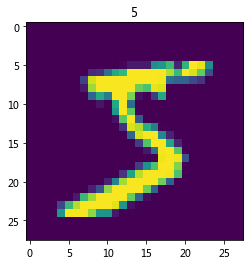

In [17]:
for image, label in mnist_dataset:
    plt.title(label.numpy())
    plt.imshow(image.numpy()[:,:,0])
    plt.show()
    break

In [ ]:
import pandas as pd 
df = pd.read_csv('heart.csv')

In [ ]:
df.head()

In [ ]:
df.dtypes

In [ ]:
df['thal'] = pd.Categorical(df['thal'])
df['thal'] = df.thal.cat.codes

In [ ]:
target = df.pop('target')

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [ ]:
for feat, targ in dataset.take(5):
    print('feature:{}, target:{}').format(feat, targ)

#### 从Python generator构建数据管道

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, rotation_range=20)

In [ ]:
flowers = './flower_photos/flower_photos'

In [ ]:
def Gen():
    gen = img_gen.flow_from_directory(flowers)
    for (x,y) in gen:
        yield (x,y)

In [ ]:
ds = tf.data.Dataset.from_generator(
    Gen,
    output_types=(tf.float32, tf.float32)
)

In [ ]:
for image, label in ds:
    print(image.shape,label.shape)
    break

#### TFRecordDataset类

In [ ]:
feature_description ={
    # 定义Feature结构，告诉解码器每个Feature的类型是什么
    'image':tf.io.FixedLenFeature([], tf.string),
    'label':tf.io.FixedLenFeature([],tf.int64)
}

In [ ]:
def _parse_example(example_string):
    # 将TFRecord文件中的每一个序列化的tf.train.Example解码
    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image']) #解码JPEG图片
    feature_dict['image'] = tf.iamge.resize(feature_dict['image'],[256,256])/255.0 #解码JPEG图片
    return feature_dict(['image'],feature_dict['label'])

batch_size = 32

train_dataset = tf.data.TFRecordDataset('sub_train.tfrecords') # 读取 TFRecord文件

train_dataset = train_dataset.map(_parse_example)

In [1]:
for line in train_dataset:
    print(line)
    break

NameError: name 'train_dataset' is not defined

#### TextLineDataset类

In [ ]:
titanic_lines  = tf.data.TextLineDataset(['./data/titanic/train.csv','./data/titanic/eval.csv'])

In [ ]:
def data_func(line):
    line = tf.strings.split(line, sep = ',')
    return line

In [ ]:
titanic_data = titanic_lines.skip(1).map(data_func) # 跳过表头名称

In [ ]:
for line in titanic_data: # 输出多个Tensor
    print(line)
    break